# Soiaporn model

Prototype the Metropolis-within-Gibbs sampling technique presented in Soiaporn et al. 2012.

The full conditionals:

$$
F_T | f, \lambda, D \sim Gamma \bigg(N_C +1, \frac{1}{1/s + (1 - f)\epsilon_0 + f \sum_{k \geq 1} w_k \epsilon_k}\bigg)
$$

$$
P(\lambda_i | F_T, f, D) \propto \frac{f_{\lambda_i}}{\epsilon_{\lambda_i}} h_{\lambda_i}
$$

Where $h_{j} = (1 - f) \epsilon_0$ if $j = 0$ and $h_j = fw_j\epsilon_j$ if $j \geq 1$.

$$
P(f | \lambda, F_T, D) \propto e^{-F_T [  (1 - f)\epsilon_0  + f \sum_{k \geq 1} \epsilon_k w_k] } \times (1-f)^{m_0(\lambda) + b - 1}f^{N_C - m_0(\lambda)+a-1}
$$


$F_T$ and $\lambda$ are sampled directly from the gamma and multinomial distributions. $f$ is sampled using a random walk Metropolis algorithm with Gaussian proposals centred on the current value of $f$. The variance of the proposal distribution was tuned to give an acceptance rate of 25%.

$\kappa$ is treated specially, they consider a logarithmically spaced grid of values to condition on. So, treat $\kappa$ as fixed. 

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from fancy import Data
import pystan
import seaborn as sns
from metropolis_within_gibbs import *
sns.set_style("dark")

## Set up

Define input parameters and data. NB: $A = 3000 km^2$ and $\alpha_T = 20370 km^2 sr year$ are defined in `soiaporn_functions.py`.

In [9]:
# fixed parameters
#kappa = 100
kappa_c = 1000

# hyperparametrs
a = 1 
b = 1
s = 0.01 * 4 * np.pi

In [10]:
# load data
uhecr_file = 'data/augerUHECR_data2010.dat'
source_file = 'data/agn_catalog.dat'

data = Data()
data.add_source(source_file, 'AGN')
data.add_uhecr(uhecr_file, 'Auger2010')

N_C = len(data.uhecr.energy)
theta = np.deg2rad(data.uhecr.incidence_angle)
d = data.uhecr.unit_vector
varpi = data.source.unit_vector
D = data.source.distance

In [11]:
# integral tables
from fancy.interfaces.integration import ExposureIntegralTable
my_table_file = 'tableforfig4.data.R'

a_0 = np.deg2rad(-35.5)
theta_m = np.deg2rad(60)
params = []
params.append(np.cos(a_0))
params.append(np.sin(a_0))
params.append(np.cos(theta_m))

kappa = [10, 31.6, 100, 316, 1000]

#my_table = ExposureIntegralTable(kappa, varpi, params, filename = my_table_file)
#my_table.build()

eps = np.transpose(pystan.read_rdump(my_table_file)['table'])
alpha_T = 20370
M = 7.42
eps = eps * alpha_T / M

## Recreate Fig. 4 in Soiaporn et al. 

Find the marginal posterior of $f$ for the different values of $\kappa$: [10, 31.6, 100, 316, 1000]. Use all the UHECR data.

In [13]:
sample_set = []

for i in range(len(kappa)):
    input_data = InputData(d, theta, varpi, D, eps[i])
    input_parameters = InputParameters(kappa[i], kappa_c, a, b, s)
    sampler = MetropolisWithinGibbs(input_data, input_parameters)
    sampler.Sample(Niter = 5000, Nchain = 2)
    sample_set.append(sampler.total_samples)

/Users/fran/projects/bayes/astroparticle/soiaporn_model/metropolis_within_gibbs/soiaporn_functions.py:83: RuntimeWarning: invalid value encountered in log
  term2 = np.log((1 - f)**(m_0 + b - 1) * f**(N_C - m_0 + a - 1))


Sampling completed
------------------
rhat f: 1.00
rhat F_T: 1.00
accepted fraction: 0.43

Sampling completed
------------------
rhat f: 1.00
rhat F_T: 1.00
accepted fraction: 0.43

Sampling completed
------------------
rhat f: 1.00
rhat F_T: 1.00
accepted fraction: 0.43

Sampling completed
------------------
rhat f: 1.00
rhat F_T: 1.00
accepted fraction: 0.42

Sampling completed
------------------
rhat f: 1.00
rhat F_T: 1.00
accepted fraction: 0.41



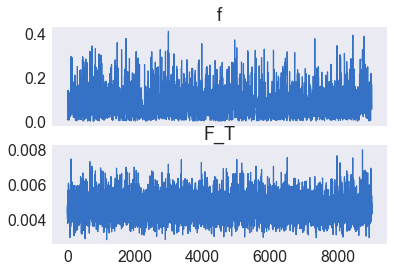

In [14]:
sampler.traceplot()

/Users/fran/projects/bayes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


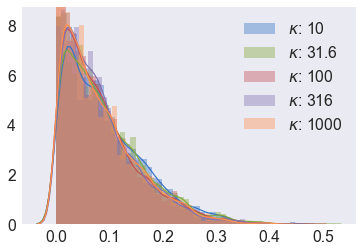

In [15]:
# plot
for i in range(len(sample_set)):
    sns.distplot(sample_set[i].f, label = '$\kappa$: ' + str(kappa[i]))
plt.legend()

## Debug

In [ ]:
def scale_F_T(s, f, eps, w):
    sum_term = 0
    for k in range(len(eps)):
        sum_term += w[k] * eps[k]
    denom = (1 + s) + ((1 - f) * (alpha_T / 4 * np.pi)) + (f * sum_term)
    return 1 / denom
def get_weights(D):

    w = []
    norm = 0

    for d in D:
        norm += 1 / d**2

    for d in D:
        w.append( (1 / d**2) / norm )

    return w
w = get_weights(D)
f = 0.00001
a = scale_F_T(s, f, eps[i], w)
print(a)